In [1]:
import matplotlib.pyplot as plt;
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.model_selection import KFold

In [2]:
##--------------------------------------------------------------------DATA-----------------------------------------------------------##

path=r''
traData = pd.read_csv(path+'trainingGroup.csv',index_col=None, header=None)
#traData = pd.read_csv('D:\\drive\\publications_2017\\datasets\\NSL-KDD\\NSL-KDD\\testingData.csv'  , index_col = None , header = None)
tesData = pd.read_csv(path+'testingGroup.csv',index_col=None, header=None)
target = 41

y_train_ori = traData[[target]].values.reshape(len(traData)) 
x_train_ori = preprocessing.normalize(traData.iloc[:,:-1])

y_test_ori = tesData[[target]].values.reshape(len(tesData)) 
x_test_ori = preprocessing.normalize(tesData.iloc[:,:-1])

def chooseObsMan(dic_f, y_train_list):
    chosenIDs=np.array(())
    for k,d in dic_f.items():
        temp=np.where(y_train_list==k)[0]
        z=np.random.choice(temp,dic_f[k], replace=True)
        chosenIDs=np.concatenate((chosenIDs,z))
    return np.int64(chosenIDs)
def label_index(row,threshold=0):
    
    if threshold==0:
        threshold=np.max(row)
    temp_i=np.where(row>=threshold)[0]
    if temp_i.shape[0]>0:
        return temp_i[0]+1
    else:
        return -1


In [3]:
#percentages = [10, 20, 30, 40]
#percentages = [0.1, 0.2, 0.3, 0.4]
#percentages = [0.001, 0.002, 0.003, 0.004]     #never work
percentages = [0.01, 0.02, 0.03, 0.04]

In [4]:
Accuracy_list_OurModel = []
Fscore_list_OurModel = []
overAllAcc_OurModel=[]

for perc in percentages:

    y_train = y_train_ori
    x_train = x_train_ori

    y_test = y_train_ori
    x_test = x_train_ori

    ##--------------------------------------------------------------------Our MODULE-----------------------------------------------------------##

    labelled=np.zeros(x_train.shape[0])
    labelled[:]=-1
    labelledIndex = np.random.choice(x_train.shape[0], int(x_train.shape[0]* (perc/100)), replace=False)   #labelling on percentages
    #li={1:60,2:60,3:30,4:10,5:10}
    #labelledIndex=chooseObsMan(li, y_train)
    labelled[labelledIndex]=y_train[labelledIndex]

    clfs ={}
    clf1=BernoulliNB()
    clf2=KNeighborsClassifier(n_jobs=-1)
    clf3=RandomForestClassifier ( n_estimators = 20 , random_state = 0 ,n_jobs=-1)
    clf4=SVC(kernel='rbf', probability=True)
    clf5=tree.DecisionTreeClassifier()
    clf7=AdaBoostClassifier()
    clf8=QuadraticDiscriminantAnalysis()

    #clfs=[('NB', clf1),('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
    #clfs=[('NB', clf1), ('KNN', clf2), ('RFC', clf3), ('SVC', clf4)]
    #clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4), ('j48', clf5)]
    #clfs=[('KNN', clf2), ('RFC', clf3), ('j48', clf5)]
    clfs1=[('NB', clf1),('j48', clf5), ('RFC', clf3)]
    #clfs=[('RFC', clf3),('SVC', clf4), ('j48', clf5)]
    #clfs=[('KNN', clf2), ('RFC', clf3),('SVC', clf4)]
    clfs2=[('NB', clf1)]


    #Model1
    threshold=0.99
    leftNumber=-1
    temp_left_Group=np.arange(x_train.shape[0])
    for i in range(0,x_train.shape[0]):
        temp_left=sum(labelled==-1)
        if temp_left<=0:
            break
        ensemble_models = VotingClassifier(estimators=clfs2, voting='soft')
        #print(x_train[labelled!=-1].shape)
        ensemble_models.fit(x_train[labelled!=-1],y_train[labelled!=-1])
        predicted=ensemble_models.predict_proba(x_train[labelled==-1])
        final_decition=np.apply_along_axis(label_index, 1, predicted,threshold)
        labelled[labelled==-1]=final_decition
        if temp_left==leftNumber:
            threshold-0.01
        threshold_step=0.1
        leftNumber=temp_left
        temp_left=sum(labelled==-1)
        temp_left_Group[i]=temp_left
        #print([temp_left,threshold])
        #print(temp_left, threshold, (final_decition != -1).mean() *400000 , (predicted != -1).mean() *400000)
        if i >0:
            change_rate=temp_left_Group[i-1] - temp_left_Group[i]
            if(change_rate<1000):
                threshold=threshold-threshold_step

    #print(i)

    #print("------------------------------------Our Module---------------------------------------")
    #print('threshold step=',threshold_step)


    #print('\n*********Training*********\n')
            
    pre=labelled[labelled!=-1]
    org=y_train[labelled!=-1]
    pop=metrics.precision_recall_fscore_support(org, pre,labels=[1, 2, 3,4, 5])
    results = pd.DataFrame();
    for i in range(0,len(pop)):
        temp = pd.DataFrame([pop[i]],columns=['normal','DoS','Probe','R2L','U2R'])
        results=results.append(temp, ignore_index=True)

    #print(len(clfs1),'Classifier')

    results.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(results)
    resultsDataFrame1 = results
    correctLabelled=metrics.accuracy_score(org, pre,normalize=False)
    incorrectLabelled=sum(results.iloc[3,1:])-correctLabelled
    #print([correctLabelled,incorrectLabelled])
    ourModelTrainingAcc = correctLabelled/(correctLabelled + incorrectLabelled)

    numbers=results.iloc[3,1:]
    correctLabelledForEachclass=results.iloc[3,1:] *results.iloc[1,1:]
    incorrectLabelledForEachclass=results.iloc[3,1:]-correctLabelledForEachclass
    results1 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results1['Total'] = numbers
    results1['Correct'] = correctLabelledForEachclass
    results1['Incorrect'] = incorrectLabelledForEachclass
    #print(results1)

    
    #print('\n*********Testing*********\n')
    def chooseObsManTest(dic_f):
        chosenIDs=np.array(())
        for k,d in dic_f.items():
            temp=np.where(y_test==k)[0]
            z=np.random.choice(temp,dic_f[k],replace=True)
            chosenIDs=np.concatenate((chosenIDs,z))
        return np.int64(chosenIDs)

    labelledTest=np.zeros(x_test.shape[0])
    labelledTest[:]=-1
    li={1:60,2:60,3:30,4:10,5:10}
    labelledIndexTest=chooseObsManTest(li)
    labelledTest[labelledIndexTest]=y_test[labelledIndexTest]

    leftNumberTest=-1
    temp_left_GroupTest=np.arange(x_test.shape[0])
    for i in range(0,x_test.shape[0]):
        temp_leftTest=sum(labelledTest==-1)
        if temp_leftTest<=0:
            break
        #ensemble_models = VotingClassifier(estimators=clfs2, voting='soft')
        #ensemble_models.fit(x_train[labelled!=-1],y_train[labelled!=-1])
        predictedTest=ensemble_models.predict_proba(x_test[labelledTest==-1])
        final_decitionTest=np.apply_along_axis(label_index, 1, predictedTest,threshold)
        labelledTest[labelledTest==-1]=final_decitionTest
        if temp_left==leftNumber:
            threshold-0.01
        threshold_step=0.01
        leftNumberTest=temp_leftTest
        temp_leftTest=sum(labelledTest==-1)
        temp_left_GroupTest[i]=temp_leftTest
        #print([temp_left,threshold])
        if i >0:
            change_rate=temp_left_Group[i-1] - temp_left_Group[i]
            if(change_rate<1000):
                threshold=threshold-threshold_step

    preTest=labelledTest[labelledTest!=-1]
    orgTest=y_test[labelledTest!=-1]
    popTest=metrics.precision_recall_fscore_support(orgTest, preTest,labels=[1, 2, 3,4, 5])
    resultsTest = pd.DataFrame()
    for i in range(0,len(popTest)):
        tempTest = pd.DataFrame([popTest[i]],columns=['normal','DoS','Probe','R2L','U2R'])
        resultsTest=resultsTest.append(tempTest, ignore_index=True)

    resultsTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(resultsTest)
    resultsDataFrame1Test = resultsTest
    correctLabelledTest=metrics.accuracy_score(orgTest, preTest,normalize=False)
    incorrectLabelledTest=sum(resultsTest.iloc[3,1:])-correctLabelledTest
    #print([correctLabelledTest,incorrectLabelledTest])
    ourModelTestingAcc = correctLabelledTest / (correctLabelledTest + incorrectLabelledTest)

    numbersTest=resultsTest.iloc[3,1:]
    correctLabelledForEachclassTest=resultsTest.iloc[3,1:] *resultsTest.iloc[1,1:]
    incorrectLabelledForEachclassTest=resultsTest.iloc[3,1:]-correctLabelledForEachclassTest
    results1Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results1Test['Total'] = numbersTest
    results1Test['Correct'] = correctLabelledForEachclassTest
    results1Test['Incorrect'] = incorrectLabelledForEachclassTest
    #print(results1Test)
    

    acc = []
    for i in range (5) :
        acc.append(round( ((results1.iloc[i,1] / results1.iloc[i,0])*100) ,2))
    Accuracy_list_OurModel.append(acc)

    Facc = []
    for i in range (5) :
        Facc.append(round( (results.iloc[2,i+1])*100 ,2))
    Fscore_list_OurModel.append(Facc)

    overAllAcc_OurModel.append(ourModelTrainingAcc)


In [5]:
Accuracy_list_Paper1 = []
Fscore_list_Paper1 = []
overAllAcc_Paper1 = []

#iKn=1
for perc in percentages:

    y_train = y_train_ori
    x_train = x_train_ori

    y_test = y_train_ori
    x_test = x_train_ori

    labelledIndex = np.random.choice(x_train.shape[0], int(x_train.shape[0]* (perc/100)), replace=False)   #labelling on percentages

    
    ##--------------------------------------------------------------------Paper1-----------------------------------------------------------##


    #method to find the nearest clusters :--- output is 5
    ## ---->>> takes so  much time use it if u want
    def findBestclusters():
        kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42, }
        # A list holds the SSE values for each k
        sse = []
        for k in range(1, 25):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(x_train)
            sse.append(kmeans.inertia_)

        plt.style.use("fivethirtyeight")
        plt.plot(range(1, 25), sse)
        plt.xticks(range(1, 25))
        plt.xlabel("Number of Clusters")
        plt.ylabel("SSE")
        plt.show()

        kl = KneeLocator(range(1, 25), sse, curve="convex", direction="decreasing")
        return kl.elbow    #result is 5

    #print(findBestclusters())

    kmeans = KMeans( init="random", n_clusters=10, n_init=10, max_iter=300, random_state=42).fit(x_train)

    # Final locations of the centroid
    #print(kmeans.cluster_centers_)

    # The number of iterations required to converge
    #print(kmeans.n_iter_)

    clusters = np.full((10, 6), 0, dtype=int)
    for i in range(kmeans.labels_.shape[0]):
        clusters[ kmeans.labels_[i] ][ y_train[i] ] = clusters[ kmeans.labels_[i] ][ y_train[i] ] + 1

    df = pd.DataFrame(clusters[:,1:11]
                        , index = ["Cluster0", "Cluster1", "Cluster2", "Cluster3", "Cluster4","Cluster5", "Cluster6", "Cluster7", "Cluster8", "Cluster9"]
                        , columns=['normal', 'DoS', 'Probe', 'R2L', 'U2R'])

    #print("------------------------------------Paper 1---------------------------------------")

    #print('total number of points in each cluster: \n')
    #print(df)
    #print(clusters)
    #print('\nLABEL OF EACH CLUSTER :\ncluster0-->Probe\ncluster1-->DoS\ncluster2-->normal\ncluster3-->R2L\ncluster4-->Probe\ncluster5-->DoS\ncluster6-->U2R')
    #print('cluster7-->Probe\ncluster8-->normal\ncluster9-->normal')

    #KNN model using Kmeans results
    clustering_out = [3, 2, 1, 4, 3, 2, 5, 3, 1, 1]
    clustering_out_label = ['Probe', 'DoS', 'normal', 'R2L', 'Probe', 'DoS', 'U2R', 'Probe', 'normal', 'normal']

    knn_model = KNeighborsRegressor(n_neighbors=1)
    knn_model.fit(kmeans.cluster_centers_, clustering_out)

    #print('\n*********Training*********\n')

    train_preds = knn_model.predict(x_train[labelledIndex])

    #print((train_preds == y_train).mean())

    matrices = metrics.precision_recall_fscore_support(y_train[labelledIndex], train_preds,labels=[1, 2, 3, 4, 5])
    resultsDataFrame = pd.DataFrame()
    for i in range(0,len(matrices)):
        temp = pd.DataFrame([matrices[i]],columns=['normal','DoS','Probe','R2L','U2R'])
        resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)
    resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])

    #print(resultsDataFrame)
    resultsDataFrame2 = resultsDataFrame

    correctLabelled=metrics.accuracy_score(y_train[labelledIndex], train_preds,normalize=False)
    incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
    #print([correctLabelled,incorrectLabelled])

    Paper1TrainingAcc = correctLabelled / (correctLabelled + incorrectLabelled)

    numbers=resultsDataFrame.iloc[3,1:]
    correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
    incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
    results2 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results2['Total'] = numbers
    results2['Correct'] = correctLabelledForEachclass
    results2['Incorrect'] = incorrectLabelledForEachclass
    #print(results2)

    '''
    #print('\n*********Testing*********\n')

    Test_preds = knn_model.predict(x_test)

    #print((Test_preds == y_test).mean())

    matricesTest = metrics.precision_recall_fscore_support(y_test, Test_preds,labels=[1, 2, 3, 4, 5])
    resultsDataFrameTest = pd.DataFrame()
    for i in range(0,len(matricesTest)):
        tempTest = pd.DataFrame([matricesTest[i]],columns=['normal','DoS','Probe','R2L','U2R'])
        resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)
    resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])

    #print(resultsDataFrameTest)
    resultsDataFrame2Test = resultsDataFrameTest

    correctLabelledTest=metrics.accuracy_score(y_test, Test_preds,normalize=False)
    incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
    #print([correctLabelledTest,incorrectLabelledTest])

    #Paper1TestingAcc = correctLabelledTest / (correctLabelledTest + incorrectLabelledTest)

    numbersTest=resultsDataFrameTest.iloc[3,1:]
    correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
    incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
    results2Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results2Test['Total'] = numbersTest
    results2Test['Correct'] = correctLabelledForEachclassTest
    results2Test['Incorrect'] = incorrectLabelledForEachclassTest
    #print(results2Test)
    '''


    acc = []
    for i in range (5) :
        acc.append(round( ((results2.iloc[i,1] / results2.iloc[i,0])*100) ,2))
    Accuracy_list_Paper1.append(acc)

    Facc = []
    for i in range (5) :
        Facc.append(round( (resultsDataFrame2.iloc[2,i+1])*100 ,2))
    Fscore_list_Paper1.append(Facc)

    overAllAcc_Paper1.append(Paper1TrainingAcc)

C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-2da02f4703cf>:141: RuntimeWarning: invalid value encountered in double_scalars
  acc.append(round( ((results2.iloc[i,1] / results2.iloc[i,0])*100) ,2))
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-2da02f4703cf>:141: RuntimeWarning: invalid value encountered in double_scalars
  acc.append(round( ((results2.iloc

In [6]:
Accuracy_list_Paper2 = []
Fscore_list_Paper2 = []
overAllAcc_Paper2 = []

#iKn=1
for perc in percentages:

    y_train = y_train_ori
    x_train = x_train_ori

    y_test = y_train_ori
    x_test = x_train_ori

    ##--------------------------------------------------------------------Paper 2-----------------------------------------------------------##


    #print("------------------------------------Paper 2---------------------------------------")

    #print('\n*********Training*********\n')

    labelled=np.zeros(x_train.shape[0])
    labelled[:]=-1
    labelledIndex = np.random.choice(x_train.shape[0], int(x_train.shape[0]* (perc/100)), replace=False)   #labelling on percentages
    #li={1:60,2:60,3:30,4:10,5:10}
    #labelledIndex=chooseObsMan(li, y_train)
    labelled[labelledIndex]=y_train[labelledIndex]

    clf = GaussianNB()
    clf.fit(x_train[labelled!=-1],y_train[labelled!=-1])
    predicted = clf.predict(x_train)

    matrices = metrics.precision_recall_fscore_support(y_train, predicted,labels=[1, 2, 3, 4, 5])
    resultsDataFrame = pd.DataFrame()
    for i in range(0,len(matrices)):
        temp = pd.DataFrame([matrices[i]],columns=['normal','DoS','Probe','R2L','U2R'])
        resultsDataFrame = resultsDataFrame.append(temp, ignore_index=True)


    resultsDataFrame.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(resultsDataFrame)
    resultsDataFrame3 = resultsDataFrame

    correctLabelled=metrics.accuracy_score(y_train, predicted,normalize=False)
    incorrectLabelled=sum(resultsDataFrame.iloc[3,1:]) - correctLabelled
    #print([correctLabelled,incorrectLabelled])

    Paper2TrainingAcc = correctLabelled / (correctLabelled + incorrectLabelled)

    numbers=resultsDataFrame.iloc[3,1:]
    correctLabelledForEachclass=resultsDataFrame.iloc[3,1:] *resultsDataFrame.iloc[1,1:]
    incorrectLabelledForEachclass=resultsDataFrame.iloc[3,1:]-correctLabelledForEachclass
    results3 = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results3['Total'] = numbers
    results3['Correct'] = correctLabelledForEachclass
    results3['Incorrect'] = incorrectLabelledForEachclass
    #results3.iloc[0,1] = results3.iloc[0,1]/2 - 0.5 - 5000
    #results3.iloc[0,2] = results3.iloc[0,1] + 0.5 + 5000
    #print(results3)

    #print('\n*********Testing*********\n')

    predictedTest = clf.predict(x_test)

    matricesTest = metrics.precision_recall_fscore_support(y_test, predictedTest,labels=[1, 2, 3, 4, 5])
    resultsDataFrameTest = pd.DataFrame()
    for i in range(0,len(matricesTest)):
        tempTest = pd.DataFrame([matricesTest[i]],columns=['normal','DoS','Probe','R2L','U2R'])
        resultsDataFrameTest = resultsDataFrameTest.append(tempTest, ignore_index=True)


    resultsDataFrameTest.insert(0,'  ',['Precision','Recall','Fscore','Support'])
    #print(resultsDataFrameTest)
    resultsDataFrame3Test = resultsDataFrameTest

    correctLabelledTest=metrics.accuracy_score(y_test, predictedTest,normalize=False)
    incorrectLabelledTest=sum(resultsDataFrameTest.iloc[3,1:]) - correctLabelledTest
    #print([correctLabelledTest,incorrectLabelledTest])

    Paper2TestingAcc = correctLabelledTest / (correctLabelledTest + incorrectLabelledTest)

    numbersTest=resultsDataFrameTest.iloc[3,1:]
    correctLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:] *resultsDataFrameTest.iloc[1,1:]
    incorrectLabelledForEachclassTest=resultsDataFrameTest.iloc[3,1:]-correctLabelledForEachclassTest
    results3Test = pd.DataFrame(columns = ['Total','Correct', 'Incorrect'])
    results3Test['Total'] = numbersTest
    results3Test['Correct'] = correctLabelledForEachclassTest
    results3Test['Incorrect'] = incorrectLabelledForEachclassTest
    #results3Test.iloc[0,1] = results3Test.iloc[0,1]/2 - 2000
    #results3Test.iloc[0,2] = results3Test.iloc[0,1] + 2000
    #print(results3Test)

    acc = []
    for i in range (5) :
        acc.append(round( ((results3.iloc[i,1] / results3.iloc[i,0])*100) ,2))
    Accuracy_list_Paper2.append(acc)

    Facc = []
    for i in range (5) :
        Facc.append(round( (resultsDataFrame3.iloc[2,i+1])*100 ,2))
    Fscore_list_Paper2.append(Facc)

    overAllAcc_Paper2.append(Paper2TrainingAcc)


C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Sayed Mansour\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont


Over all accuracy :


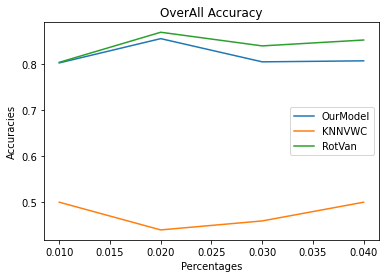

In [7]:
def makePlot(x, y1, y2, y3, tit, tit2):
    plt.plot(x, y1, label = "OurModel")
    plt.plot(x, y2, label = "KNNVWC")
    plt.plot(x, y3, label = "RotVan")
    plt.xlabel('Percentages')
    plt.ylabel(tit2)
    plt.title(tit)
    plt.legend()
    plt.show()

#Accuracy
#percs = ['10%','20%','30%','40%']
percs = percentages
print('\nOver all accuracy :')
makePlot(percs,np.array(overAllAcc_OurModel), np.array(overAllAcc_Paper1), np.array(overAllAcc_Paper2), 'OverAll Accuracy', 'Accuracies')

#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 0], np.array(Accuracy_list_Paper1)[:, 0], np.array(Accuracy_list_Paper2)[:, 0], 'Normal', 'Accuracies')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 1], np.array(Accuracy_list_Paper1)[:, 1], np.array(Accuracy_list_Paper2)[:, 1], 'Dos', 'Accuracies')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 2], np.array(Accuracy_list_Paper1)[:, 2], np.array(Accuracy_list_Paper2)[:, 2], 'Probe', 'Accuracies')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 3], np.array(Accuracy_list_Paper1)[:, 3], np.array(Accuracy_list_Paper2)[:, 3], 'R2L', 'Accuracies')
#makePlot(percs,np.array(Accuracy_list_OurModel)[:, 4], np.array(Accuracy_list_Paper1)[:, 4], np.array(Accuracy_list_Paper2)[:, 4], 'U2R', 'Accuracies')

#F-Score
#percs = ['10%','20%','30%','40%']
#print('\nF-Score For Each percentage :')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 0], np.array(Fscore_list_Paper1)[:, 0], np.array(Fscore_list_Paper2)[:, 0], 'Normal', 'F score')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 1], np.array(Fscore_list_Paper1)[:, 1], np.array(Fscore_list_Paper2)[:, 1], 'Dos', 'F score')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 2], np.array(Fscore_list_Paper1)[:, 2], np.array(Fscore_list_Paper2)[:, 2], 'Probe', 'F score')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 3], np.array(Fscore_list_Paper1)[:, 3], np.array(Fscore_list_Paper2)[:, 3], 'R2L', 'F score')
#makePlot(percs,np.array(Fscore_list_OurModel)[:, 4], np.array(Fscore_list_Paper1)[:, 4], np.array(Fscore_list_Paper2)[:, 4], 'U2R', 'F score')


In [8]:
dt = pd.DataFrame(columns = ['OurModel','KNNVWC', 'RotVan'])
dt['OurModel'] = overAllAcc_OurModel
dt['KNNVWC'] = overAllAcc_Paper1
dt['RotVan'] = overAllAcc_Paper2
lis = []
lis.append(np.mean(overAllAcc_OurModel))
lis.append(np.mean(overAllAcc_Paper1))
lis.append(np.mean(overAllAcc_Paper1))
new_row = {'OurModel': lis[0] , 'KNNVWC':lis[0], 'RotVan':lis[0]}
dt = dt.append(new_row, ignore_index=True)

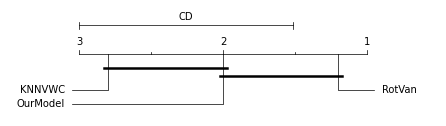

In [9]:
from autorank import autorank, plot_stats, create_report, latex_table

result = autorank(dt, alpha=0.05, verbose=False)
#result_bayesian = autorank(data, alpha=0.05, verbose=False, approach='bayesian')
plot_stats(result)
plt.show()